# Installations

In [1]:
# tested on python 3.8.16 on Macbook Air M1
%pip install pydicom matplotlib rt_utils scikit-learn scikit-image torch # install dependencies
# restart kernel

  Using cached pydicom-2.4.1-py3-none-any.whl (1.8 MB)
  Using cached matplotlib-3.7.1-cp38-cp38-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached rt_utils-1.2.7-py2.py3-none-any.whl (18 kB)
  Using cached scikit_learn-1.2.2-cp38-cp38-macosx_10_9_x86_64.whl (9.0 MB)
  Using cached scikit_image-0.21.0-cp38-cp38-macosx_10_9_x86_64.whl (12.9 MB)
  Using cached torch-2.0.1-cp38-none-macosx_10_9_x86_64.whl (143.1 MB)
  Using cached contourpy-1.1.0-cp38-cp38-macosx_10_9_x86_64.whl (243 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.40.0-cp38-cp38-macosx_10_9_x86_64.whl (2.1 MB)
  Using cached kiwisolver-1.4.4-cp38-cp38-macosx_10_9_x86_64.whl (65 kB)
  Using cached numpy-1.24.3-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached Pillow-9.5.0-cp38-cp38-macosx_10_10_x86_64.whl (3.4 MB)
  Using cached pyparsing-3.1.0-py3-none-any.whl (102 kB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached opencv_python-4.7.0.72-cp37-ab

# Begin

#### Import necessary packages

In [1]:
# import required packages
import pydicom # pydicom is a package for working with DICOM files such as medical images, reports, and radiotherapy objects
import os # os module provides functions for interacting with the operating system
import matplotlib.pyplot as plt # matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy
import numpy as np # NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
from rt_utils import RTStructBuilder # rt_utils is a package for working with DICOM RT structure sets
import re # re module provides regular expression matching operations
from sklearn.model_selection import train_test_split # sklearn.model_selection is a module for splitting arrays or matrices into random train and test subsets
import numpy as np # for working with arrays
from skimage.transform import resize # for resizing images
import copy # for copying objects
import torch 

# Start

#### Functions

In [2]:
# this function will load the dicom images and mask from the given directory
def load_data(dicom_dir, rtstruct_dir):
    rtstruct = RTStructBuilder.create_from(
    dicom_series_path=dicom_dir[:-1], 
    rt_struct_path=rtstruct_dir
    )  # Load existing RT Struct. Requires the series path and existing RT Struct path

    # print(rtstruct.get_roi_names()) # view all of the ROI names from within the image

    mask_3d = rtstruct.get_roi_mask_by_name("GTV_Mass") # loading the 3D Mask from within the RT Struct

    image_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')] # get a list of all DICOM files in the directory
    image_files.sort(reverse=True) # sort the image_files by their name
    images = {pydicom.dcmread(f).SOPInstanceUID: pydicom.dcmread(f) for f in image_files} # load the DICOM images

    return images, mask_3d


def view_data(images, mask_3d):
    # Display all slices of the region
    for i in range(mask_3d.shape[2]):
        uid = list(images.keys())[i]  # get the SOPInstanceUID of the ith image
        plt.imshow(images[uid].pixel_array, cmap='gray') # plot the ith image

        mask_slice = mask_3d[:, :, i]
        plt.imshow(mask_slice, cmap='jet', alpha=0.5) # overlay the mask with transparency
        plt.axis('off')
        plt.show()

# this function will return a flat list of image and mask directory 
def get_image_mask_pairs(data_dict): 
    pairs = []

    for key, value in data_dict.items():
        if isinstance(value, dict):
            pairs.extend(get_image_mask_pairs(value))
        elif key == 'image' or key == 'mask':
            pairs.append(value)
    return pairs


# this function will turn the flat list of image and mask directory into a list of paired image and mask directory
def reshape_array(arr):
    paired_array = [[arr[i], arr[i + 1]] for i in range(0, len(arr)-1, 2)]
    for i in paired_array:
        if 'dcm' in i[0]:
            i[0], i[1] = i[1], i[0]

    return paired_array


# this function takes the array of paired image and mask directory and separates them based on their modalities
def separate_modalities(arr):
    fdg_pet_ct = []
    mr = []
    aligned = []

    for i in arr:
        if 'RTstructCT' in i[1] or 'RTstructPET' in i[1]:
            fdg_pet_ct.append(i)
        elif 'RTstructT1' in i[1] or 'RTstructT2' in i[1] or 'RTstructSTIR' in i[1]:
            mr.append(i)
        elif 'RTstructAligned' in i[1]:
            aligned.append(i)
        else:
            print("i")
            break

    return fdg_pet_ct, mr, aligned


# TODO: Refine this function to be less hardcoded
# this function explores the dataset and returns a dictionary of patients with their corresponding study, with its corresponding image and mask directory
def extract_ds(root_dir, file_extension=".dcm"):
    patient_images = {f"dataset/Soft-tissue-Sarcoma/STS_{i:03d}": {} for i in range(1, 11)} # initialize the dictionary of patients

    for root, dirs, files in os.walk(root_dir): # walk through the root directory
        for file in files: 
            parent_dir = os.path.dirname(root) # get the parent directory of the current root
            grandparent_dir = os.path.dirname(parent_dir) # get the grandparent directory of the current root


            if 'STIR' in os.path.basename(root) and 'RTstruct' in os.path.basename(root): # checks if dir contains string "STIR" and "RTstruct"
                if parent_dir not in patient_images[grandparent_dir]: # if parent_dir is not in patient_images[grandparent_dir], add it
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'STIR' not in patient_images[grandparent_dir][parent_dir]: # if 'STIR' is not in patient_images[grandparent_dir][parent_dir], add it
                    patient_images[grandparent_dir][parent_dir]['STIR'] = {}
                patient_images[grandparent_dir][parent_dir]['STIR']['mask'] = os.path.join(root,'1-1.dcm') # add the rtstruct image to patient_images[grandparent_dir][parent_dir]['STIR']['image']
            
            
            elif 'RTstruct' in os.path.basename(root) and 'T1toPET' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T1toPET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T1toPET'] = {}
                patient_images[grandparent_dir][parent_dir]['T1toPET']['mask'] = os.path.join(root,'1-1.dcm')


            elif 'RTstruct' in os.path.basename(root) and 'T2FStoPET' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T2FStoPET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T2FStoPET'] = {}
                patient_images[grandparent_dir][parent_dir]['T2FStoPET']['mask'] = os.path.join(root,'1-1.dcm')


            elif 'RTstruct' in os.path.basename(root) and 'CT' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'CT' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['CT'] = {}
                patient_images[grandparent_dir][parent_dir]['CT']['mask'] = os.path.join(root,'1-1.dcm')


            elif 'RTstruct' in os.path.basename(root) and 'PET' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'PET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['PET'] = {}
                patient_images[grandparent_dir][parent_dir]['PET']['mask'] = os.path.join(root,'1-1.dcm')


            elif 'RTstruct' in os.path.basename(root) and 'T1' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T1' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T1'] = {}
                patient_images[grandparent_dir][parent_dir]['T1']['mask'] = os.path.join(root,'1-1.dcm')
            

            elif 'RTstruct' in os.path.basename(root) and 'T2' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T2' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T2'] = {}
                patient_images[grandparent_dir][parent_dir]['T2']['mask'] = os.path.join(root,'1-1.dcm')


            elif 'STIR' in os.path.basename(root) and '.' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'STIR' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['STIR'] = {}
                patient_images[grandparent_dir][parent_dir]['STIR']['image'] = root
                break


            elif 'T1toPET' in os.path.basename(root) and '.' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T1toPET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T1toPET'] = {}
                patient_images[grandparent_dir][parent_dir]['T1toPET']['image'] = root
                break


            elif 'T2FStoPET' in os.path.basename(root) and '.' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T2FStoPET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T2FStoPET'] = {}
                patient_images[grandparent_dir][parent_dir]['T2FStoPET']['image'] = root
                break


            elif ('CT' in os.path.basename(root) or 'Standard' in os.path.basename(root)) and '.' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'CT' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['CT'] = {}
                patient_images[grandparent_dir][parent_dir]['CT']['image'] = root
                break


            elif ('PET' in os.path.basename(root) or 'DAC' in os.path.basename(root)) and '.' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'PET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['PET'] = {}
                patient_images[grandparent_dir][parent_dir]['PET']['image'] = root
                break
            

            elif 'T1' in os.path.basename(root) and '.' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T1' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T1'] = {}
                patient_images[grandparent_dir][parent_dir]['T1']['image'] = root
                break


            elif 'T2' in os.path.basename(root) and '.' in os.path.basename(root):
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T2' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T2'] = {}
                patient_images[grandparent_dir][parent_dir]['T2']['image'] = root
                break

    return patient_images


# this function is used to visualize the dictionary tree
def print_dictionary_tree(dictionary, indent=0):
    for key, value in dictionary.items():
        print('  ' * indent + '- ' + str(key))
        if isinstance(value, dict):
            print_dictionary_tree(value, indent + 1)
        else:
            print('  ' * (indent + 1) + '- ' + str(value))


# this function takes the array genereated by reshape_data() and loads all the images-mask pairs into a single list
def load_data_from_array(array):
    data = [[] for i in range(len(array))]

    for i in range(len(array)):
        #print(i) # for debugging
        image, mask = load_data(array[i][0] + '/', array[i][1] ) # loads the image-mask pair
        data[i].append(image)
        data[i].append(mask)
    
    return data

#### Main program

In [3]:
root_dir = "dataset/Soft-tissue-Sarcoma" # path to dataset
ds_dict = extract_ds(root_dir) # extracts dataset into dictionary

ds_array = reshape_array(get_image_mask_pairs(ds_dict)) # turns the ds_dict into an array of image-mask directory pairs
#print(ds_array) # view the array

fdg_pet, ct, aligned = separate_modalities(ds_array) # separates the modalities into separate lists
# TODO: need to debug when we include entire dataset

fdg_pet_data = load_data_from_array(fdg_pet) 
ct_data = load_data_from_array(ct)
aligned_data = load_data_from_array(aligned) # loads the data into a list of readable image-mask pairs
# TODO: need to debug when we include entire dataset

#### Data Overview

This shows us 

In [4]:
print_dictionary_tree(ds_dict) # view the dictionary tree

- dataset/Soft-tissue-Sarcoma/STS_001
  - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929
    - CT
      - image
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/2.000000-CT IMAGES - RESEARCH-38601
      - mask
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructCT-77278/1-1.dcm
    - T1toPET
      - mask
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructAlignedT1toPET-92485/1-1.dcm
      - image
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/5436027.000000-AlignedT1toPETBOX-88600
    - PET
      - image
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-PET AC-51583
      - mask
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructPET-17357/1-1.dcm
    - T2FStoPET
      - mask
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructAlignedT2FSt

In [8]:
# split the data into training and testing sets
fdg_pet_train, fdg_pet_test = train_test_split(fdg_pet_data, test_size=0.2, random_state=42)
ct_train, ct_test = train_test_split(ct_data, test_size=0.2, random_state=42)
aligned_train, aligned_test = train_test_split(aligned_data, test_size=0.2, random_state=42)

# Dataloader

In [9]:
fdg_pet_train_extract = []

for i in range(len(fdg_pet_train)):
    for j in range(fdg_pet_train[i][1].shape[2]):
        uid = list(fdg_pet_train[i][0].keys())[j]
        fdg_pet_train_extract.append([fdg_pet_train[i][0][uid].pixel_array, fdg_pet_train[i][1][:, :, j]])
 


In [10]:
fdg_pet_test_extract = []

for i in range(len(fdg_pet_test)):
    for j in range(fdg_pet_test[i][1].shape[2]):
        uid = list(fdg_pet_test[i][0].keys())[j]
        fdg_pet_test_extract.append([fdg_pet_test[i][0][uid].pixel_array, fdg_pet_test[i][1][:, :, j]])

In [34]:
len(fdg_pet_train_extract)

4360

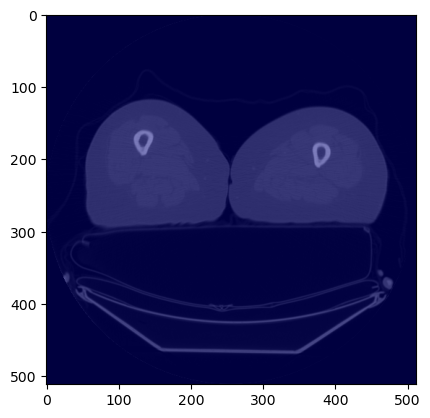

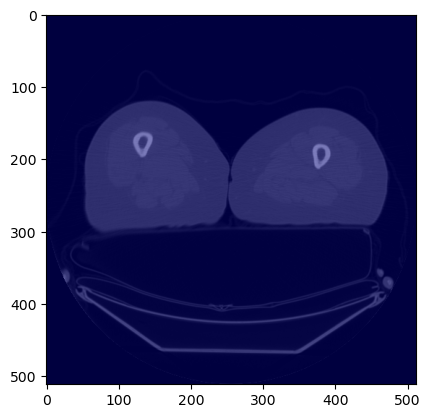

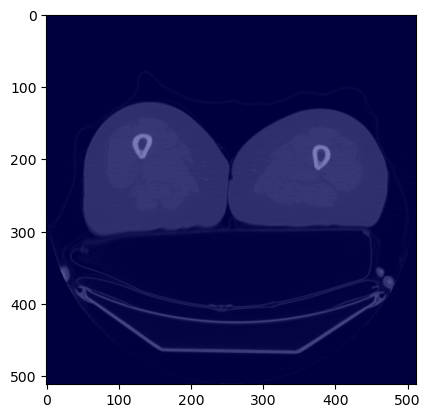

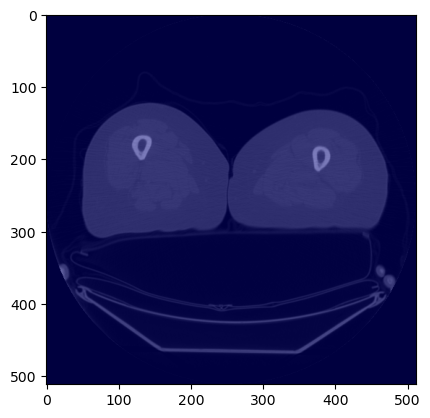

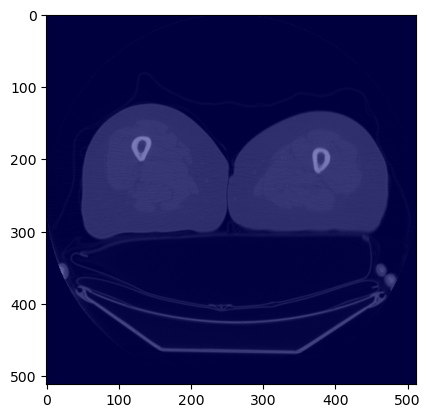

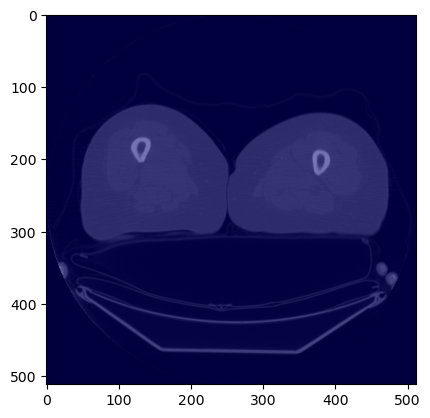

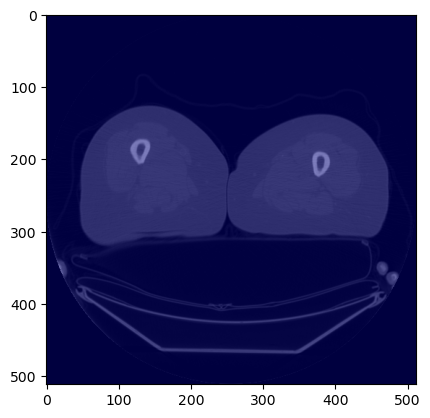

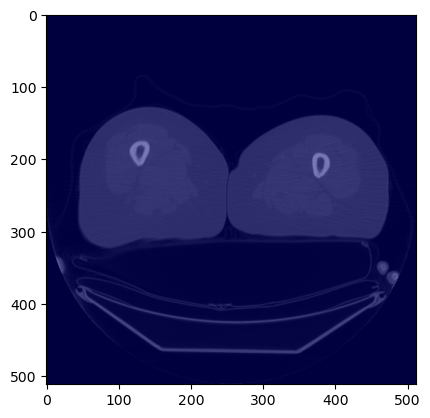

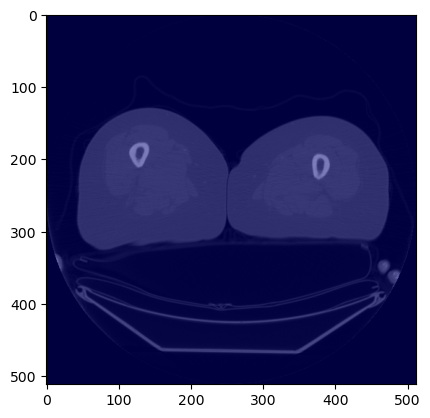

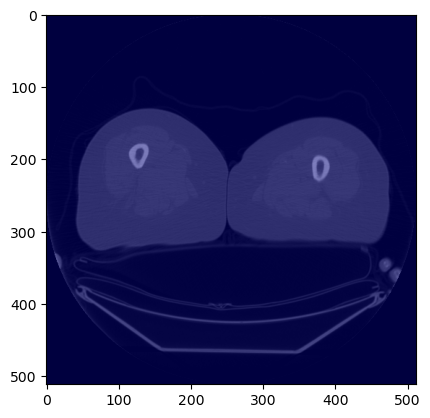

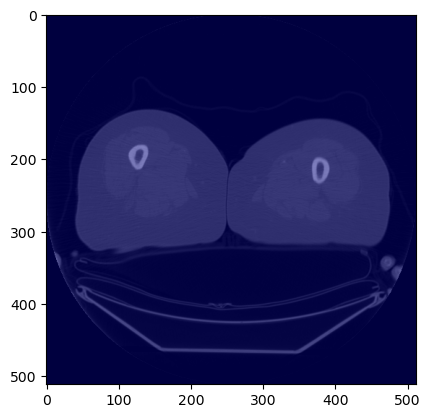

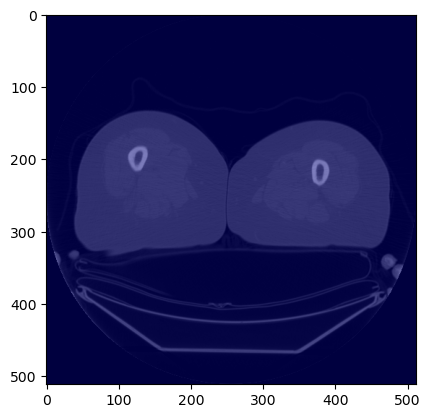

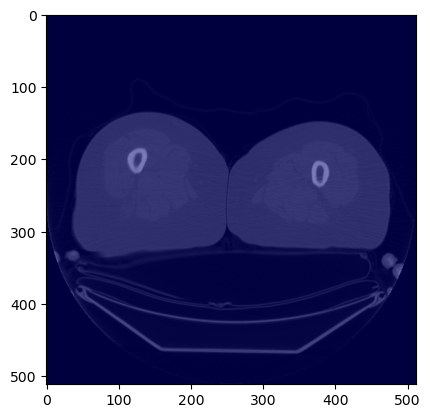

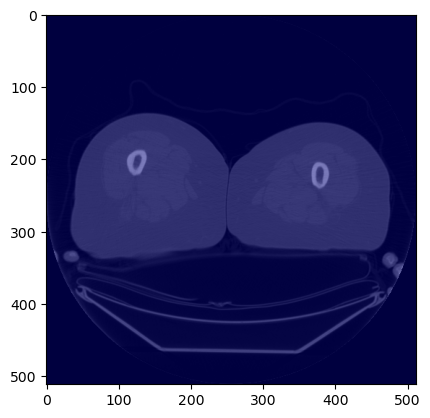

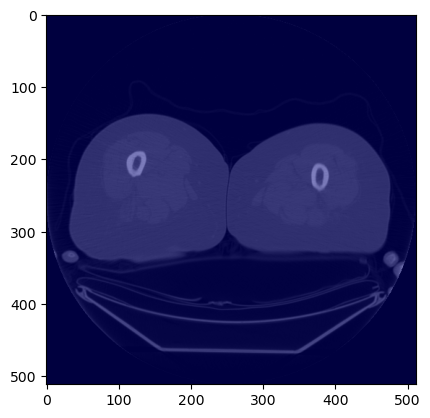

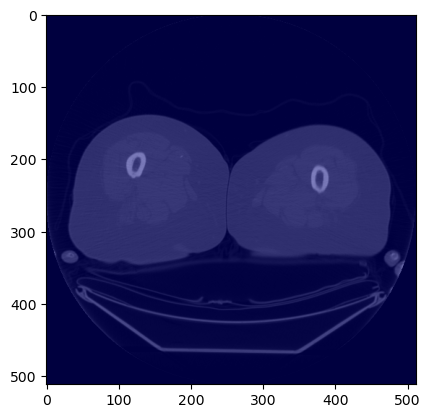

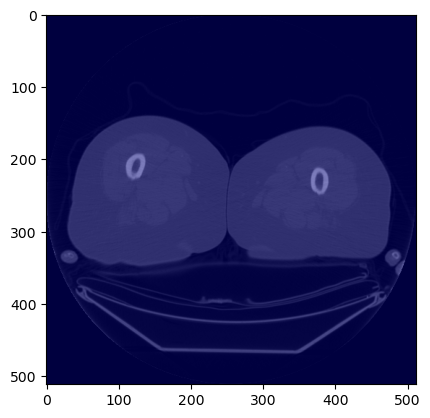

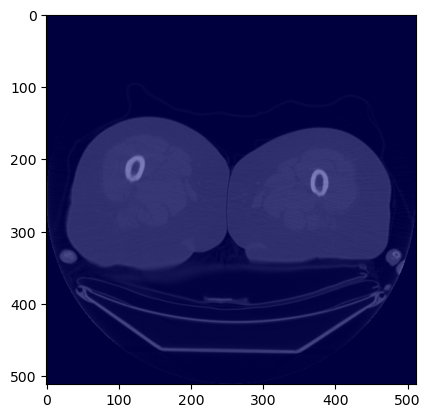

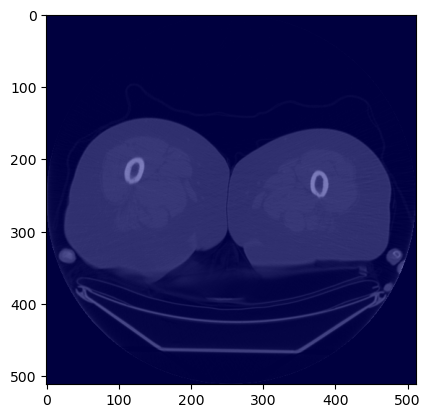

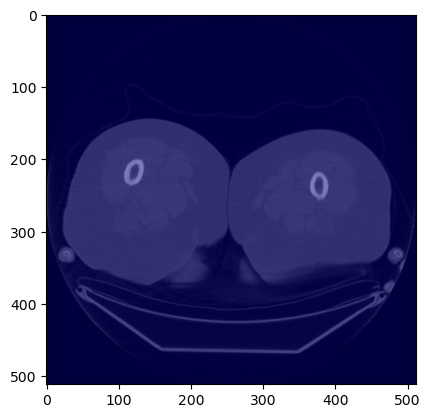

KeyboardInterrupt: 

In [15]:
for i in range(len(fdg_pet_train_extract)):
    plt.imshow(fdg_pet_train_extract[i][0].pixel_array, cmap='gray')
    plt.imshow(fdg_pet_train_extract[i][1], cmap='jet', alpha=0.5)
    plt.show()

In [35]:
type(fdg_pet_train_extract[0][0])

pydicom.dataset.FileDataset

In [27]:
fdg_pet_train_extract[0][0].pixel_array.shape

(512, 512)

In [33]:
len(mask_data)

512